# Frequentist parameter estimation for synthetic data

## Imports

In [95]:
import numpy as np
import scipy as sp
import pandas as pd
import math as math
import random
import time
import matplotlib.pyplot as plt

from scipy.integrate import solve_ivp as solve
from scipy.optimize import minimize
from gekko import GEKKO
from tqdm import tqdm

## Predator Prey Model

$\frac{\mathrm{d} p}{\mathrm{d} t} = ap(t) - bp(t)r(t)$

$\frac{\mathrm{d} r}{\mathrm{d} t} = -cr(t) + dp(t)r(t)$

In [96]:
#prey growth rate, predator influence on prey death, 
#predator death rate, prey influence on predator growth,
#prey population, predator population
# [a, b, c, d, initial_prey, initial_predator]

parameters = np.array([1.2, 0.1, 0.6, 0.05, 20, 10])
guess2 = np.array([1, 0.1, 1, 0.1, 10, 10])

In [97]:
def change(t, population,params):
    prey, predator = population
    dpdt = params[0] * prey - params[1] * prey * predator 
    drdt = -params[2] * predator + params[3] * prey * predator 
    return [dpdt, drdt]

In [98]:
##Testing the change function
y = change(0, parameters[4:],parameters[:4])
print(y)

[np.float64(4.0), np.float64(4.0)]


In [99]:
#setting time evaluation points
t_data = np.array([0, 20])
t_plot = np.array([0, 40])
t_points_data = np.linspace(0, 20, 20)
t_points_plot = np.linspace(0, 40, 120)

In [100]:
# Data generation: 0 to 20
lambda_fun_data = lambda t, y: change(t, y, parameters[:4])
solution_data = solve(lambda_fun_data, t_data, parameters[4:], t_eval=t_points_data, method="RK45")
prey_data = solution_data.y[0]
predator_data = solution_data.y[1]

# Plotting: 20 to 40
lambda_fun_plot = lambda t, y: change(t, y, parameters[:4])
solution_plot = solve(lambda_fun_plot, t_plot, [prey_data[-1], predator_data[-1]], t_eval=t_points_plot, method="RK45")

Text(0.5, 1.0, 'Predator Prey Dynamics')

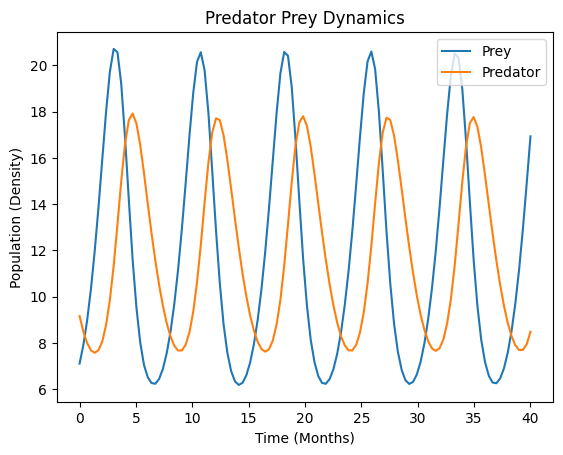

In [101]:
plt.plot(solution_plot.t,solution_plot.y[0]) #prey
plt.plot(solution_plot.t,solution_plot.y[1]) #predator
plt.legend(['Prey','Predator']) 
plt.xlabel("Time (Months)")
plt.ylabel("Population (Density)")
plt.title("Predator Prey Dynamics")

## Adding Noise

In [102]:
np.random.seed(7252004)

In [103]:
prey_data = solution_data.y[0]
predator_data = solution_data.y[1]

In [104]:
# Updated add_noise function to work with data arrays, not solution objects
def add_noise(data, variance):
    noise = np.random.normal(0, variance, size=data.shape)
    noisy_data = data + noise
    return noisy_data

In [105]:
prey_noisy_01 = add_noise(prey_data, 0.1)
prey_noisy_05 = add_noise(prey_data, 0.5)
prey_noisy_1 = add_noise(prey_data, 1)

predator_noisy_01 = add_noise(predator_data, 0.1)
predator_noisy_05 = add_noise(predator_data, 0.5)
predator_noisy_1 = add_noise(predator_data, 1)

In [106]:
np.save('prey_noisy_1.npy', prey_noisy_1) 
np.save('predator_noisy_1.npy', predator_noisy_1)

In [107]:
column_names = ['prey', 'pred']
df_noisy = pd.DataFrame({'prey': prey_noisy_1, 'pred': predator_noisy_1})
df_noisy.to_csv('pred_prey_synthetic_data_noisy.csv', index=False, header=False)

## Approximating Parameters

In [108]:
##Defining the objective function
def objective(params, prey_data, predator_data, t_points):
    model_params = np.array(params[:4])
    initial = np.array(params[4:])

    # penalize + don't run negative parameters or initial conditions
    if np.any(model_params < 0) or np.any(initial < 0):
        return 1e10
    
    # solve with given positive parameters and initial conditions
    try:
        # create a lambda function for the change function with fixed parameters, so the solve() function won't break
        lambda_fun = lambda t, y: change(t, y, model_params)
        true_solution = solve(lambda_fun, [t_points[0], t_points[-1]], initial, t_eval=t_points)
        prey_model = true_solution.y[0]
        predator_model = true_solution.y[1]
        # penalize if it breaks
        if prey_model.shape != prey_data.shape or predator_model.shape != predator_data.shape:
            return 1e10
        # penalize if doesn't work numerically (ABNORMAL message)
        if np.any(np.isnan(prey_model)) or np.any(np.isnan(predator_model)):
            return 1e10
        # penalize if it returns infinite values
        if np.any(np.isinf(prey_model)) or np.any(np.isinf(predator_model)):
            return 1e10
    except Exception: # if it breaks in another way also penalize (catch other errors)
        return 1e10
    prey_residuals = prey_model - prey_data
    predator_residuals = predator_model - predator_data
    residuals = np.stack([prey_residuals, predator_residuals], axis=1)
    total = np.sum(np.linalg.norm(residuals, axis=1) ** 2)
    
    return total

In [109]:
#testing
test_param = np.array([1.2, 0.1, 0.6, 0.05,20,10])
objective(test_param, prey_data, predator_data, t_points_data)

np.float64(0.0)

This is a good test, as feeding the objective function our original parameters should result in 0, which we observe!

In [110]:
def optimize_parameters(my_iterations, my_tolerance,prey_data, predator_data, t_points):
    guess = np.array([1,0.1,1,0.1,10,10])
    result = minimize(
        objective, 
        guess, 
        args = (prey_data, predator_data,t_points), 
        method = 'Nelder-Mead',
        bounds = [(1e-4, None), (1e-4, None), (1e-4, None), (1e-4, None), (0.01, None),(0.01, None)],
        options = {'maxiter': my_iterations,'ftol' : my_tolerance}
    )
    print(result)
    print("Parameter percent difference:" + str(np.abs((result.x - parameters) / parameters) * 100))
    return result

In [111]:
time_start = time.time()
my_iterations = 1000

result = optimize_parameters(my_iterations, 1e-6, prey_data, predator_data, t_points_data)
print("Time taken:", time.time() - time_start)
print("Time per iteration:", (time.time() - time_start) / my_iterations)

/var/folders/wc/ycjx6dfn63g3nw48hnm5lzr80000gn/T/ipykernel_36129/3077435974.py:3: OptimizeWarning: Unknown solver options: ftol
  result = minimize(


       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 6.973614362862119e-08
             x: [ 1.200e+00  1.000e-01  6.000e-01  5.000e-02  2.000e+01
                  1.000e+01]
           nit: 520
          nfev: 811
 final_simplex: (array([[ 1.200e+00,  1.000e-01, ...,  2.000e+01,
                         1.000e+01],
                       [ 1.200e+00,  1.000e-01, ...,  2.000e+01,
                         1.000e+01],
                       ...,
                       [ 1.200e+00,  1.000e-01, ...,  2.000e+01,
                         1.000e+01],
                       [ 1.200e+00,  1.000e-01, ...,  2.000e+01,
                         1.000e+01]], shape=(7, 6)), array([ 6.974e-08,  8.969e-08,  1.044e-07,  1.092e-07,
                        1.767e-07,  1.954e-07,  2.054e-07]))
Parameter percent difference:[5.25543171e-04 4.25402575e-04 3.83497754e-04 1.76340405e-04
 9.41060227e-05 4.63124188e-04]
Time taken: 0.8333089351654053
Time p

## Plotting Parameter Estimation

In [112]:
random.seed(7252004)
np.random.seed(7252004)

In [113]:
result = optimize_parameters(1000, 1e-12, prey_noisy_1, predator_noisy_1, t_points_data)

guess_parameters = result.x

def guess_change(t, population):
    prey, predator = population
    dpdt = guess_parameters[0] * prey - guess_parameters[1] * prey * predator
    drdt = - guess_parameters[2] * predator + guess_parameters[3] * prey * predator
    return [dpdt, drdt]

initial_guess = np.array(guess_parameters[4:])
guess_solution = solve(guess_change, t_data, initial_guess, t_eval=t_points_data, method="RK45")

/var/folders/wc/ycjx6dfn63g3nw48hnm5lzr80000gn/T/ipykernel_36129/3077435974.py:3: OptimizeWarning: Unknown solver options: ftol
  result = minimize(


       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 31.467122565610353
             x: [ 1.513e+00  1.242e-01  4.740e-01  3.959e-02  2.032e+01
                  1.070e+01]
           nit: 858
          nfev: 1363
 final_simplex: (array([[ 1.513e+00,  1.242e-01, ...,  2.032e+01,
                         1.070e+01],
                       [ 1.513e+00,  1.242e-01, ...,  2.032e+01,
                         1.070e+01],
                       ...,
                       [ 1.513e+00,  1.242e-01, ...,  2.032e+01,
                         1.070e+01],
                       [ 1.513e+00,  1.242e-01, ...,  2.032e+01,
                         1.070e+01]], shape=(7, 6)), array([ 3.147e+01,  3.147e+01,  3.147e+01,  3.147e+01,
                        3.147e+01,  3.147e+01,  3.147e+01]))
Parameter percent difference:[26.0726797  24.17921787 21.0016389  20.82023232  1.5841813   7.0013124 ]


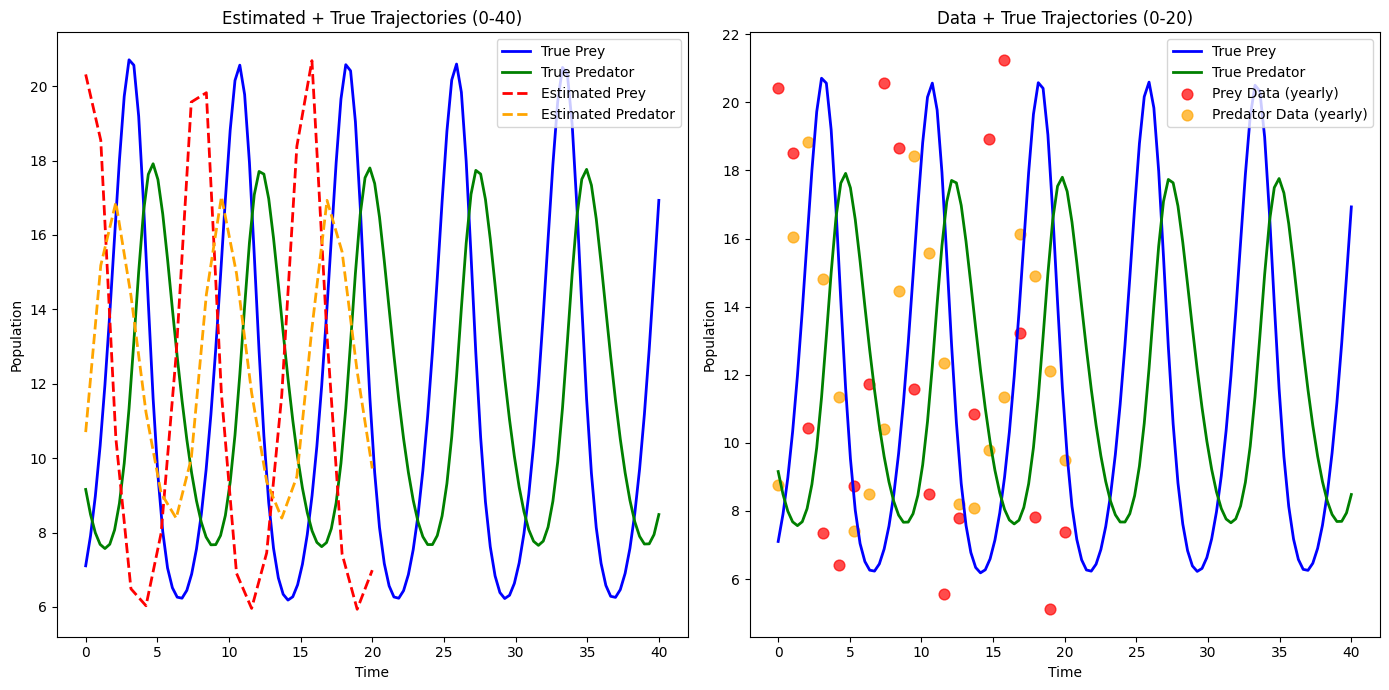

In [124]:
fig, axs = plt.subplots(1, 2, figsize=(14, 7))

# Left: Estimated + True trajectories (smooth)
axs[0].plot(t_points_plot, solution_plot.y[0], label='True Prey', color='blue', linewidth=2)
axs[0].plot(t_points_plot, solution_plot.y[1], label='True Predator', color='green', linewidth=2)
axs[0].plot(t_points_data, guess_solution.y[0], label='Estimated Prey', color='red', linestyle='--', linewidth=2)
axs[0].plot(t_points_data, guess_solution.y[1], label='Estimated Predator', color='orange', linestyle='--', linewidth=2)
axs[0].set_title("Estimated + True Trajectories (0-40)")
axs[0].set_xlabel("Time")
axs[0].set_ylabel("Population")
axs[0].legend()

# Right: Data (scatter, 20 points) + True trajectories (smooth, 120 points)
axs[1].plot(t_points_plot, solution_plot.y[0], label='True Prey', color='blue', linewidth=2)
axs[1].plot(t_points_plot, solution_plot.y[1], label='True Predator', color='green', linewidth=2)
axs[1].scatter(np.linspace(0,20,20), prey_noisy_1, label='Prey Data (yearly)', color='red', s=60, alpha=0.7)
axs[1].scatter(np.linspace(0,20,20), predator_noisy_1, label='Predator Data (yearly)', color='orange', s=60, alpha=0.7)
axs[1].set_title("Data + True Trajectories (0-20)")
axs[1].set_xlabel("Time")
axs[1].set_ylabel("Population")
axs[1].legend()

plt.savefig('synthetic_frequentist.pdf', format='pdf', dpi=300, bbox_inches='tight')

plt.tight_layout()
plt.show()

In [123]:
np.save('frequentist_parameters.npy', guess_parameters)